# Rating Prediction with Bipartite GNN

## Upload files on Colab and install packages

In [1]:
!wget https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/reviews_anonymized_fulltext.csv
!wget https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/genre_group.p

--2024-08-12 10:40:15--  https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/reviews_anonymized_fulltext.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34342967 (33M) [text/plain]
Saving to: ‘reviews_anonymized_fulltext.csv’

reviews_anonymized_ 100%[===================>]  32.75M   118MB/s    in 0.3s    

2024-08-12 10:40:17 (118 MB/s) - ‘reviews_anonymized_fulltext.csv’ saved [34342967/34342967]

--2024-08-12 10:40:17--  https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/genre_group.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP req

In [2]:
!pip install torch torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## Data Processing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import collections as clt

In [4]:
full_df = pd.read_csv('/content/reviews_anonymized_fulltext.csv')
full_df

,User,Release,Combined_Genre,Score,Cleansed Text
0,0,1011,heavy metal|us power metal,65,Here we are. The first studio release from Man...
1,0,1012,power metal,80,"The epic, Tolkien-inspired ""Nightfall In Middl..."
2,1,1013,speed metal,75,"After the first album was released, the fans q..."
3,1,1014,progressive metal,95,So comes the third album. Iron Maiden had enjo...
4,2,1015,black metal,95,This debut LP of early Scandinavian blackmetal...
...,...,...,...,...,...
9336,660,1256,progressive metal,54,"In 2003, what would your expectation of a Drea..."
9337,571,1188,folk doom metal|death doom metal,94,Another unsung hero from the US metal undergro...
9338,660,1478,power metal,60,I don’t think Hammerfall are a very complicate...
9339,571,1352,thrash metal,90,If you ask any metalhead around the world to m...


In [5]:
def isNaN(x):
    return x != x

In [6]:
all_users = full_df['User'].unique()
all_releases = full_df['Release'].unique()
# all_genres = [genre_list.split('|') if not isNaN(genre_list) else [] for genre_list in full_df['Combined_Genre'] ]
# all_genres = list(set([y for x in all_genres for y in x]))
# genre2idx = {genre:i for i, genre in enumerate(all_genres)}

N_USERS = len(all_users)
N_RELEASES = len(all_releases)
# N_GENRES = len(all_genres)

N_USERS, N_RELEASES #, N_GENRES

(1011, 634)

In [7]:
import pickle

# genre_group stores a dictionary which maps the original genres into fewer genres
# to reduce computational complexity

with open('/content/genre_group.p', 'rb') as f:
    genre_group = pickle.load(f)
    all_genres = set(genre_group.values())
    genre2idx = {genre:i for i, genre in enumerate(all_genres)}
    N_GENRES = len(all_genres)

N_GENRES, (N_USERS + N_RELEASES) * N_GENRES

(21, 34545)

In [8]:
train_df, test_df = train_test_split(full_df, shuffle=True,random_state=42)
train_df

,User,Release,Combined_Genre,Score,Cleansed Text
3527,425,1190,gothenburg metal,99,"Everyone knows At the Gates, Gothenburg metal,..."
179,9,1151,melodic metalcore,89,KSE are a band that come under fire from a lot...
8633,920,1334,teutonic thrash metal,99,"In 1985, thrash metal was finally starting to ..."
5579,716,1349,black metal,10,I've often said that black metal band members ...
2820,242,1027,thrash metal,100,Anthrax represents a sort of “road not taken” ...
...,...,...,...,...,...
5734,665,1272,symphonic black metal,95,"Even though this well known, sold and discusse..."
5191,517,1590,black metal,80,"We are sorry, the review Inquisition - Ominous..."
5390,575,1530,black metal,77,"By this time, Vreid have established just as p..."
860,133,1370,black metal,48,The first song is the best one on the album – ...


In [9]:
import torch
from torch_geometric.data import Data
import collections as clt
from tqdm import tqdm

def compute_node_features(df):
    node2genres = [[]] * (N_USERS + N_RELEASES)

    print("Processing Node Features")
    for _, row in tqdm(df.iterrows()):
        if not isNaN(row['Combined_Genre']):
            genre_list = list(set([genre_group[x] for x in row['Combined_Genre'].split('|') if x in genre_group]))
            # genre_list = row['Combined_Genre'].split('|')
            node2genres[row['User']] += genre_list
            node2genres[row['Release']] += genre_list

    node2genres = [clt.Counter(genres) for genres in node2genres]

    X = torch.zeros((N_USERS + N_RELEASES, N_GENRES))

    print("Generating Node Features")
    for i, genres_count in tqdm(enumerate(node2genres)):
        for genre in genres_count:
            X[i][genre2idx[genre]] = genres_count[genre]

    return X

node_features = compute_node_features(full_df)

Processing Node Features


9341it [00:01, 7096.01it/s]


Generating Node Features


1645it [00:00, 4249.23it/s]


In [10]:
node_features.shape

torch.Size([1645, 21])

## Define DistilBERT

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
from transformers import AutoModel, AutoTokenizer

model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# Load pre-trained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name)

text_model.to(device)

# Freeze all the parameters
for param in text_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [13]:
def get_text_features(texts, batch_size=32):
    all_pooled = []

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
        pooled = torch.mean(embeddings, dim=1)  # Shape: [batch_size, hidden_dim]

        all_pooled.append(pooled)

    # Concatenate all the pooled embeddings
    all_pooled = torch.cat(all_pooled, dim=0)  # Shape: [total_texts, hidden_dim]

    return all_pooled.cpu()

def process_data(df, X):
    edge_index = []
    edge_target = []

    texts = []

    print("Processing Edges and Targets")
    for _, row in tqdm(df.iterrows()):
        edge_index.append([row['User'], row['Release']])
        edge_target.append([row['Score']])
        texts.append(row['Cleansed Text'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_target = torch.tensor(edge_target, dtype=torch.float)
    data = Data(x=X, edge_index=edge_index, y=edge_target)
    data.texts = get_text_features(texts)

    return data


In [14]:
from torch_geometric.data import InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, root, df, transform=None, pre_transform=None):
        self.df = df
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = [process_data(self.df, node_features)]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

train_dataset = GraphDataset('train',train_df)
# train_dataset.process()
test_dataset = GraphDataset('test',test_df)
# test_dataset.process()

Processing...


Processing Edges and Targets


7005it [00:00, 8376.57it/s]
100%|██████████| 219/219 [00:32<00:00,  6.74it/s]
Done!
Processing...


Processing Edges and Targets


2336it [00:00, 18889.87it/s]
100%|██████████| 73/73 [00:10<00:00,  6.82it/s]
Done!


In [15]:
TEXT_DIM = train_dataset[0].texts.shape[1]

train_dataset[0], TEXT_DIM

(Data(x=[1645, 21], edge_index=[2, 7005], y=[7005, 1], texts=[7005, 384]), 384)

In [16]:
from torch_geometric.loader import DataLoader

data_size = len(train_dataset)
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE, shuffle=False)

print(f'# Training Samples: {len(train_dataset.y)}')
print(f'# Test Samples: {len(test_loader.dataset.y)}')

# Training Samples: 7005
# Test Samples: 2336


## Define GNN

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GatedGraphConv, GATConv

class BipartiteGNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size=512, dropout_prob=0.2):
        super(BipartiteGNN, self).__init__()

        self.dropout_prob = dropout_prob

        self.gcn_r2u = GCNConv(in_channels, hidden_size)
        self.gcn_u2r = GCNConv(hidden_size, hidden_size)

        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)

        self.gated_convs1 = GatedGraphConv(out_channels=hidden_size, num_layers=2)
        self.gated_convs2 = GatedGraphConv(out_channels=hidden_size, num_layers=2)


        self.gat1 = GATConv(hidden_size, hidden_size // 8, heads=8, dropout=self.dropout_prob)
        self.gat2 = GATConv(hidden_size, hidden_size // 8, heads=8, dropout=self.dropout_prob)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 + TEXT_DIM, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(hidden_size, out_channels)
        )

        self.dropout = nn.Dropout(p=self.dropout_prob)

    def forward(self, x, edge_index, texts):
        x = self.gcn_r2u(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.gcn_u2r(x, edge_index[[1, 0]])
        x = F.relu(x)
        x = self.layer_norm1(x)
        x = self.dropout(x)

        residual = x

        x = self.gated_convs1(x, edge_index)
        x = F.relu(x)
        x = self.gated_convs2(x, edge_index[[1, 0]])
        x = self.layer_norm2(x)
        x = self.dropout(x)

        x = residual + x

        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.gat2(x, edge_index[[1, 0]])
        x = F.relu(x)
        x = self.layer_norm3(x)
        x = self.dropout(x)

        x = residual + x

        u, r = edge_index

        x = torch.cat([x[u], x[r], texts], dim=1)
        x = self.fc(x)

        return x

model = BipartiteGNN(N_GENRES, 1).to(device)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

BipartiteGNN(
  (gcn_r2u): GCNConv(21, 512)
  (gcn_u2r): GCNConv(512, 512)
  (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (gated_convs1): GatedGraphConv(512, num_layers=2)
  (gated_convs2): GatedGraphConv(512, num_layers=2)
  (gat1): GATConv(512, 64, heads=8)
  (gat2): GATConv(512, 64, heads=8)
  (fc): Sequential(
    (0): Linear(in_features=1408, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of parameters:  5726721


In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

## Train GNN

In [19]:
def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_index, batch.texts)
        loss = loss_fn(pred.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss /= len(train_loader.dataset)
    return total_loss

def valid():
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in test_loader:
        with torch.no_grad():
            batch.to(device)
            pred = model(batch.x.float(), batch.edge_index, batch.texts)
            loss = loss_fn(pred.squeeze(), batch.y)
            total_loss += loss.item()

            all_preds.append(pred.squeeze().cpu())
            all_labels.append(batch.y.cpu())


    all_preds = torch.cat(all_preds, dim = 0)
    all_labels = torch.cat(all_labels, dim = 0)
    total_loss /= len(test_loader.dataset)

    return total_loss, all_preds, all_labels


In [20]:
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 10000
print("Starting training...")
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train()
    valid_loss, _, _ = valid()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} / {EPOCHS} | Train Loss {train_loss:.5f} | Valid Loss {valid_loss:.5f}")


Starting training...
Epoch 0 / 10000 | Train Loss 6418.51709 | Valid Loss 5578.51904
Epoch 100 / 10000 | Train Loss 568.35156 | Valid Loss 499.85150
Epoch 200 / 10000 | Train Loss 566.48181 | Valid Loss 498.83920
Epoch 300 / 10000 | Train Loss 565.60254 | Valid Loss 498.43591
Epoch 400 / 10000 | Train Loss 564.36847 | Valid Loss 498.56387
Epoch 500 / 10000 | Train Loss 564.07227 | Valid Loss 498.60522
Epoch 600 / 10000 | Train Loss 564.14813 | Valid Loss 498.59824
Epoch 700 / 10000 | Train Loss 563.68280 | Valid Loss 498.67816
Epoch 800 / 10000 | Train Loss 564.11017 | Valid Loss 498.72452
Epoch 900 / 10000 | Train Loss 563.46234 | Valid Loss 498.54745


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-8c0318400b9c>", line 11, in <cell line: 10>
    train_loss = train()
  File "<ipython-input-19-1df1fac8f4dd>", line 12, in train
    total_loss += loss.item()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_contex

TypeError: object of type 'NoneType' has no len()

## Visualize Metrics

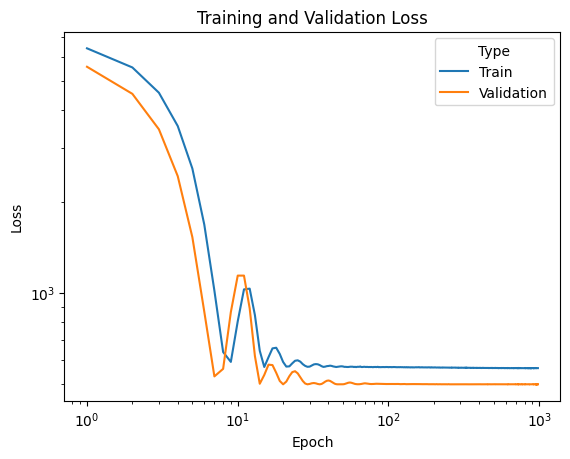

In [21]:
import seaborn as sns

# Create a DataFrame with the losses
data = {
    'Epoch': list(range(1, len(train_losses) + 1)) * 2,
    'Loss': train_losses + valid_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(valid_losses)
}

data_df = pd.DataFrame(data)

# Plot the losses
sns.lineplot(data=data_df, x='Epoch', y='Loss', hue='Type')
plt.yscale('log')
plt.xscale('log')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
test_df

,User,Release,Combined_Genre,Score,Cleansed Text
360,4,1236,brutal death metal,73,I hadn't listened to this album in about 4 yea...
9164,863,1400,gothenburg metal,96,In Flames has always been a bit of an anomaly ...
5577,714,1012,power metal,93,"As any generic metalhead will tell you, Blind ..."
7963,384,1577,heavy metal|power metal,70,The unimaginatively titled Steel Warrior satia...
7415,384,1057,thrash metal,90,"Overkill's second opus, Taking Over and yours ..."
...,...,...,...,...,...
7551,876,1485,technical deathcore,0,Whenever I feel like ripping something to shre...
8019,883,1101,melodic black metal|extreme power metal|folk m...,100,"After the release of the abysmal ""Turbo"" and t..."
3768,402,1188,folk doom metal|death doom metal,69,It took two years for Astimi to release anothe...
7898,920,1150,symphonic black metal,58,Dimmu Borgir pioneered the symphonic black met...


In [23]:
test_dataset[0].edge_index, test_dataset[0].y

(tensor([[   4,  863,  714,  ...,  402,  920,  739],
         [1236, 1400, 1012,  ..., 1188, 1150, 1389]]),
 tensor([[73.],
         [96.],
         [93.],
         ...,
         [69.],
         [58.],
         [97.]]))

In [24]:
valid_loss, preds, labels = valid()

In [25]:
compare_df = pd.DataFrame({
    'y_pred': preds.squeeze(),
    'label': labels.squeeze()
})
compare_df

,y_pred,label
0,77.325073,73.0
1,76.896812,96.0
2,77.339134,93.0
3,76.849861,70.0
4,77.049950,90.0
...,...,...
2331,77.531425,0.0
2332,77.259148,100.0
2333,77.233246,69.0
2334,77.454826,58.0


(array([  2.,  80., 561., 616., 447., 327., 176.,  70.,  41.,  16.]),
 array([76.34441376, 76.60072327, 76.85704041, 77.11334991, 77.36966705,
        77.62597656, 77.88228607, 78.13860321, 78.39491272, 78.65122986,
        78.90753937]),
 <BarContainer object of 10 artists>)

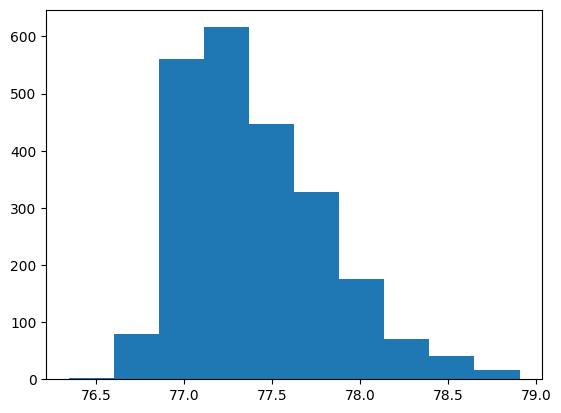

In [26]:
plt.hist(preds)